## VIX Futures Trading Simulations with Machine Learning Models

This trading simulation forecasts the one-day-ahead VIX futures front-month price using the principal components of the S&P 500 implied volatility surface. This formed the main test of economic significance in my thesis. Using a simple thresholded delta rule, the strategy achieved an economically significant Sharpe ratio of 2.12. The rule is as follows:


\begin{aligned}
& \text{If } \hat{y}_{t+1} - y_t > \text{threshold, go long and hold until } \hat{y}_{t+1} - y_t < \text{threshold.} \\
& \text{If } \hat{y}_{t+1} - y_t < -\text{threshold, go short and hold until } \hat{y}_{t+1} - y_t > -\text{threshold.} \\
& \text{Where } y_t \text{ is the current VIX front-month price on day } t, \text{ and } \hat{y}_{t+1} \text{ is the forecast for the next day.}
\end{aligned}


To better mimic real trading conditions, the simulation employed a time-series walk-forward cross-validation, as well as realistic spreads and transaction costs. Permutation tests of the returns series indicate high variance in the Sharpe ratio, with a 95% confidence interval ranging from 1.2 to 2.8.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime,timedelta, date
import os
from math import sqrt
import json


from functions.BetaNeutralOptimiser import BetaNeutralOptimiser
from functions.Sparse import Sparse
from functions.Permutations import sharpe_ratio_confidence_interval
from scipy.interpolate import griddata



from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols 
from statsmodels.api import OLS
from sklearn.preprocessing import StandardScaler


import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning, module="sklearn.metrics._regression")
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Boolean Series key will be reindexed.*")



In [2]:

data = pd.read_csv('data/vix_futures.csv')
data['Date'] = pd.to_datetime(data['Trade Date'])
data = data.groupby(['RIC','Date']).last().reset_index()
data = data[data['RIC'].isin(['VXc1'])]
data = data[data['Date'].dt.weekday < 5]  # Remove weekends
vix_data = data.pivot(index='Date',columns='RIC',values='Last').sort_values(by='Date')
# vix_data = data.pivot(index='Date',columns='RIC',values='Universal Close Price').sort_values(by='Date')
vix_data



RIC,VXc1
Date,
2004-05-03,17.80
2004-05-04,16.85
2004-05-05,16.60
2004-05-06,17.50
2004-05-07,18.14
...,...
2025-04-01,20.88
2025-04-02,22.00
2025-04-03,26.25


In [3]:
rows = vix_data.shape[0]
dropped_rows = rows - vix_data.dropna().shape[0]
dropped_percentage = (dropped_rows / rows * 100) if rows > 0 else 0
dropped_percentage

0.7587253414264037

In [4]:
print(pd.isna(vix_data).sum()/vix_data.shape[0] * 100)
vix_data = vix_data.dropna()
vix_data

RIC
VXc1    0.758725
dtype: float64


RIC,VXc1
Date,
2004-05-03,17.80
2004-05-04,16.85
2004-05-05,16.60
2004-05-06,17.50
2004-05-07,18.14
...,...
2025-04-01,20.88
2025-04-02,22.00
2025-04-03,26.25


In [5]:
def third_friday(year, month):
    third_friday = pd.date_range(start=f'{year}-{month}-15', end=f'{year}-{month}-21', freq='W-FRI')[0]
    return third_friday

def settlement_wednesday(year, month):
    nm = 1 if month == 12 else month + 1
    ny = year + 1 if month == 12 else year
    tf = third_friday(ny, nm)
    d = tf - pd.Timedelta(days=30)
    if d.weekday() != 2:  # Wednesday
        raise ValueError(f"Computed {d.date()} is not Wed; check calendar logic.")
    return d

# Mark the settlement Wednesday for each month in vix_data_cleaned
vix_data_cleaned = vix_data.copy()
vix_data_cleaned.index = pd.to_datetime(vix_data_cleaned.index)
dates = vix_data_cleaned.index
months = dates.to_period('M')
unique_months = months.drop_duplicates()
roll_dates = [settlement_wednesday(x.year, x.month) for x in unique_months]
roll_dates = pd.to_datetime(roll_dates)
vix_data_cleaned['roll'] = vix_data_cleaned.index.isin(roll_dates).astype(int)
vix_data_cleaned['roll'] = vix_data_cleaned['roll'].shift(-1)
# vix_data_cleaned = vix_data_cleaned.dropna()
## drops double column index

n_contracts = 3
betas = list(json.load(open('data/vix_futures_beta.json')).values())[:n_contracts]
y_cols = ['VXc1']  # Only first two contracts available
for col in y_cols:
    vix_data_cleaned[f'next_day_{col}'] = vix_data_cleaned[col].shift(-1)
    vix_data_cleaned[f'yesterday_{col}'] = vix_data_cleaned[col].shift(1)


vix_data_cleaned.head(40).tail(20)


RIC,VXc1,roll,next_day_VXc1,yesterday_VXc1
Date,,,,
2004-06-01,17.62,0.0,17.61,17.57
2004-06-02,17.61,0.0,17.60,17.62
2004-06-03,17.60,0.0,17.19,17.61
2004-06-04,17.19,0.0,16.64,17.60
2004-06-07,16.64,0.0,16.21,17.19
2004-06-08,16.21,0.0,16.29,16.64
2004-06-09,16.29,0.0,15.80,16.21
2004-06-10,15.80,0.0,15.80,16.29
2004-06-14,15.80,0.0,15.02,15.80


In [6]:
surface = pd.read_csv('data/3d_surface_features_filled.csv')
surface['Date'] = pd.to_datetime(surface['date'])
surface = surface.set_index('Date').drop(columns=['date'])
surface

,IV_0_0.8,IV_0_0.9,IV_0_1.0,IV_0_1.1,IV_30_0.8,IV_30_0.9,IV_30_1.0,IV_30_1.1,IV_60_0.8,IV_60_0.9,IV_60_1.0,IV_60_1.1,IV_90_0.8,IV_90_0.9,IV_90_1.0,IV_90_1.1
Date,,,,,,,,,,,,,,,,
2006-01-03,0.252729,0.134066,0.122277,0.333502,0.188052,0.128207,0.091442,0.156238,0.192731,0.132451,0.098109,0.125925,0.179779,0.144023,0.113172,0.107102
2006-01-04,0.279504,0.152788,0.114229,0.154873,0.235763,0.133042,0.091026,0.154873,0.184395,0.136447,0.098012,0.154873,0.174347,0.145589,0.113331,0.154873
2006-01-05,0.139808,0.153603,0.118460,0.139808,0.193014,0.132026,0.092627,0.139808,0.176674,0.136879,0.098186,0.139808,0.181557,0.146344,0.108517,0.139808
2006-01-06,0.267368,0.133818,0.112786,0.141017,0.176502,0.121465,0.089116,0.141017,0.169878,0.125367,0.095824,0.119611,0.174690,0.138320,0.108471,0.141017
2006-01-09,0.278829,0.143031,0.117662,0.151559,0.185374,0.124671,0.096788,0.151559,0.151559,0.151559,0.151559,0.151559,0.171750,0.137463,0.108464,0.151559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,0.334014,0.233946,0.164445,0.176090,0.285605,0.224309,0.167257,0.145201,0.275759,0.221882,0.170528,0.145302,0.265636,0.221246,0.177017,0.146078
2023-02-23,0.310637,0.215449,0.155442,0.172454,0.270422,0.210362,0.156982,0.143926,0.262937,0.209606,0.162196,0.142136,0.254055,0.210665,0.168614,0.143073
2023-02-24,0.316887,0.219247,0.164660,0.186172,0.279826,0.219259,0.165387,0.150328,0.270286,0.217864,0.170160,0.148932,0.260460,0.218112,0.174322,0.147469


In [7]:
df = vix_data_cleaned.join(surface, how='inner').dropna()
df 

,VXc1,roll,next_day_VXc1,yesterday_VXc1,IV_0_0.8,IV_0_0.9,IV_0_1.0,IV_0_1.1,IV_30_0.8,IV_30_0.9,IV_30_1.0,IV_30_1.1,IV_60_0.8,IV_60_0.9,IV_60_1.0,IV_60_1.1,IV_90_0.8,IV_90_0.9,IV_90_1.0,IV_90_1.1
Date,,,,,,,,,,,,,,,,,,,,
2006-01-03,12.03,0.0,11.82,12.49,0.252729,0.134066,0.122277,0.333502,0.188052,0.128207,0.091442,0.156238,0.192731,0.132451,0.098109,0.125925,0.179779,0.144023,0.113172,0.107102
2006-01-04,11.82,0.0,11.80,12.03,0.279504,0.152788,0.114229,0.154873,0.235763,0.133042,0.091026,0.154873,0.184395,0.136447,0.098012,0.154873,0.174347,0.145589,0.113331,0.154873
2006-01-05,11.80,0.0,11.55,11.82,0.139808,0.153603,0.118460,0.139808,0.193014,0.132026,0.092627,0.139808,0.176674,0.136879,0.098186,0.139808,0.181557,0.146344,0.108517,0.139808
2006-01-06,11.55,0.0,11.35,11.80,0.267368,0.133818,0.112786,0.141017,0.176502,0.121465,0.089116,0.141017,0.169878,0.125367,0.095824,0.119611,0.174690,0.138320,0.108471,0.141017
2006-01-09,11.35,0.0,11.25,11.55,0.278829,0.143031,0.117662,0.151559,0.185374,0.124671,0.096788,0.151559,0.151559,0.151559,0.151559,0.151559,0.171750,0.137463,0.108464,0.151559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,22.05,0.0,21.34,23.00,0.334014,0.233946,0.164445,0.176090,0.285605,0.224309,0.167257,0.145201,0.275759,0.221882,0.170528,0.145302,0.265636,0.221246,0.177017,0.146078
2023-02-23,21.34,0.0,22.25,22.05,0.310637,0.215449,0.155442,0.172454,0.270422,0.210362,0.156982,0.143926,0.262937,0.209606,0.162196,0.142136,0.254055,0.210665,0.168614,0.143073
2023-02-24,22.25,0.0,21.28,21.34,0.316887,0.219247,0.164660,0.186172,0.279826,0.219259,0.165387,0.150328,0.270286,0.217864,0.170160,0.148932,0.260460,0.218112,0.174322,0.147469


In [8]:
import importlib
import sys

# Import the submodule directly
import functions.Returns
import functions.Permutations
import functions.ReturnsGPT

# Force reload the submodule
importlib.reload(functions.Returns)
importlib.reload(functions.Permutations)
importlib.reload(functions.ReturnsGPT)



# Now re-import the function
from functions.Returns import update_daily_returns
from functions.Permutations import sharpe_ratio_confidence_interval
from functions.ReturnsGPT import update_daily_returns_2

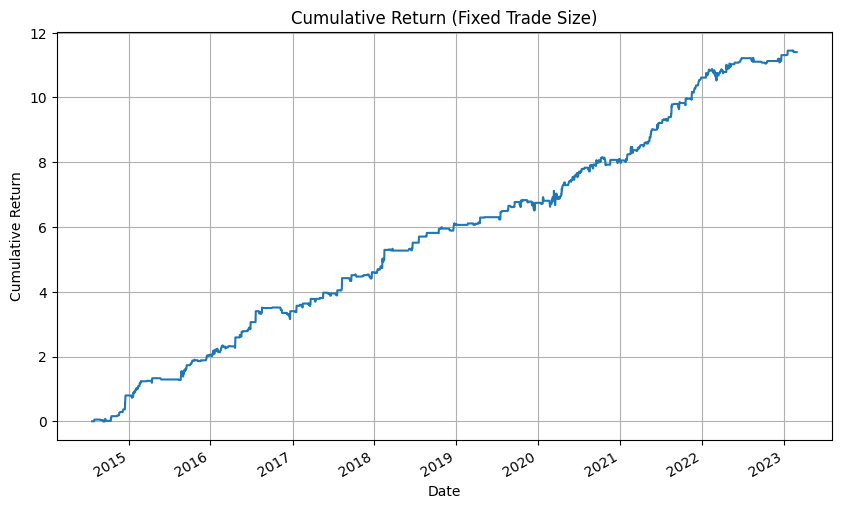

Sharpe Ratio: 2.12
Annualised Compound Return: 2.12
Fixed Trade Size Annualised Return: 0.34


,return,position,cumulative_fixed_trade_size_return
date,,,
2014-07-22,0.0,,0.000000
2014-07-23,0.0,,0.000000
2014-07-24,0.0,,0.000000
2014-07-25,0.0,,0.000000
2014-07-28,0.0,,0.000000
...,...,...,...
2023-02-22,0.0,,11.402335
2023-02-23,0.0,,11.402335
2023-02-24,0.0,,11.402335


In [9]:
initial_training_frac = 0.5
folds = 3

initial_training_size = int(initial_training_frac * len(df))
fold_size = (len(df) - initial_training_size) // folds

n_components = 3
threshold = 1
transaction_cost = 0.00025
spread = 0.025

iv_columns = [col for col in df.columns if 'IV' in col]
pc_columns = ['PC1','PC2','PC3']
# pc_columns = ['PC1','PC3']
# pc_columns = ['PC1']
# pc_columns = iv_columns


# trades = []
daily_returns = []


for fold in range(folds):
    # print(f"Processing fold {fold + 1} of {folds}...")

    start = initial_training_size + fold * fold_size
    end = start + fold_size
    
    train_data = df.iloc[:start].copy()
    test_data = df.iloc[start:end].copy()
    
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(train_data[iv_columns])

    # scaler = StandardScaler()
    # scaler.fit(train_data[iv_columns])
    # train_data[iv_columns] = scaler.transform(train_data[iv_columns])
    # test_data[iv_columns] = scaler.transform(test_data[iv_columns])

    train_data_pca = pca.transform(train_data[iv_columns])
    test_data_pca = pca.transform(test_data[iv_columns])

    for i in range(n_components):
        train_data[f'PC{i+1}'] = train_data_pca[:, i]
        test_data[f'PC{i+1}'] = test_data_pca[:, i]

    
    
    model = LinearRegression()
    model.fit(train_data[pc_columns], train_data['next_day_VXc1'])
    preds = model.predict(test_data[pc_columns])
    if model.__class__.__name__ == 'LSTMWrapper':
        test_data = test_data.iloc[model.lag:]
    test_data['predicted_VXc1'] = preds
    test_data['predicted_delta'] = test_data['predicted_VXc1'] - test_data['VXc1']


    position = ''
    entry_price = 0
    days_held = 0

    for idx in range(test_data.shape[0]):
        row = test_data.iloc[idx]
        date = row.name
        delta = row['predicted_delta']

        current_price = row['VXc1']
        yesterday_price = row['yesterday_VXc1']

        if row['roll'] == 1:
            ## turn off during rolls
            if position != '':
                if position == 'long':
                    ## close long
                    days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, '', entry_price, spread=spread, transaction_cost=transaction_cost)
                else: 
                    ## close short
                    days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, '', entry_price, spread=spread, transaction_cost=transaction_cost)
            else:
                ## no position hence 0 return
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, '', entry_price, spread=spread, transaction_cost=transaction_cost)


        elif position == '':

            if delta > threshold: 
                # enter long position
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, 'long', entry_price, spread=spread, transaction_cost=transaction_cost)
            elif delta < -threshold: 
                # enter short position
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, 'short', entry_price, spread=spread, transaction_cost=transaction_cost)
            else: 
                # stay neutral
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, '', entry_price, spread=spread, transaction_cost=transaction_cost)

        elif position == 'long':
            if delta > threshold: 
                ## stay long
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, 'long', entry_price, spread=spread, transaction_cost=transaction_cost)
            elif delta < -threshold: 
                # close long, go short
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, 'short', entry_price, spread=spread, transaction_cost=transaction_cost)
            else: 
                # close long
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, '', entry_price, spread=spread, transaction_cost=transaction_cost)

        elif position == 'short':
            if delta < -threshold: 
                # stay short
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, 'short', entry_price, spread=spread, transaction_cost=transaction_cost)
            elif delta > threshold: 
                ## close short, go long
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, 'long', entry_price, spread=spread, transaction_cost=transaction_cost)
            else: 
                # close short
                days_held, daily_returns, position, entry_price = update_daily_returns_2(date, current_price, yesterday_price, daily_returns, days_held, position, '', entry_price, spread=spread, transaction_cost=transaction_cost)

trades_daily_df = pd.DataFrame(daily_returns)
trades_daily_df['cumulative_fixed_trade_size_return'] = trades_daily_df['return'].cumsum() # fixed trade size
trades_daily_df.set_index('date', inplace=True)
trades_daily_df['cumulative_fixed_trade_size_return'].plot(title='Cumulative Return (Fixed Trade Size)', figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid()
plt.show()

sharpe_ratio = (trades_daily_df['return'].mean() / trades_daily_df['return'].std()) * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

cumulative_compound_return = (1 + trades_daily_df['return']).cumprod() 
years = (trades_daily_df.index[-1] - trades_daily_df.index[0])
years = years.days / 365.25
annualised_return = cumulative_compound_return.iloc[-1] ** (1 / years) - 1
print(f'Annualised Compound Return: {annualised_return:.2f}')

fixed_trade_return = trades_daily_df['cumulative_fixed_trade_size_return'].iloc[-1] + 1
fixed_trade_return_annualised = fixed_trade_return ** (1 / years) - 1 
print(f'Fixed Trade Size Annualised Return: {fixed_trade_return_annualised:.2f}')

trades_daily_df

In [10]:
sharpe_ratio_confidence_interval(trades_daily_df['return'], num_simulations=1000, confidence_level=0.99)


(1.2220509231412124, 2.8236367478049216)